In [220]:
import math

import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
# from scipy.optimize import minimize_scalar

In [221]:
G = 9.80665

In [222]:
class Trebuchet:
    def __init__(self, arm_ratio, frame_height, arm_length, start_angle, release_angle, missile_mass, arm_mass, logging_level=3, include_air_drag=False, missile_r=0.008):
        self.frame_height = frame_height    # Высота вала
        self.arm_ratio = arm_ratio          # Доля рычага, относящаяся к весу
        self.arm_length = arm_length        # Длина рычага
        self.missile_arm_length = arm_length * (1 - arm_ratio)
        self.weight_arm_length = arm_length * arm_ratio
        self.missile_r = missile_r / 1000

        self.missile_mass = missile_mass
        self.arm_mass = arm_mass

        self.start_angle = np.radians(start_angle)              # Углы по которым полетит снаряд / противовес
        self.release_angle = np.radians(release_angle)
        self.start_arm_angle = np.radians(start_angle + 90)     # Углы концов рычагов
        self.release_arm_angle = np.radians(release_angle + 90)

        self.start_missile_x = np.cos(self.start_arm_angle) * self.missile_arm_length                       # Начальная координата снаряда
        self.start_missile_y = np.sin(self.start_arm_angle) * self.missile_arm_length + self.frame_height
        self.start_weight_x = -np.cos(self.start_arm_angle) * self.weight_arm_length                        # Начальная координата противовеса
        self.start_weight_y = -np.sin(self.start_arm_angle) * self.weight_arm_length + self.frame_height

        self.logging_level = logging_level
        self.include_air_drag = include_air_drag

        if self.logging_level >= 2:
            print(f"Missile start point: ({self.start_missile_x}; {self.start_missile_y})")
            print(f"Weight start point: ({self.start_weight_x}; {self.start_weight_y})")

        self.release_missile_x = np.cos(self.release_arm_angle) * self.missile_arm_length
        self.release_missile_y = np.sin(self.release_arm_angle) * self.missile_arm_length + self.frame_height
        self.release_weight_x = -np.cos(self.release_arm_angle) * self.weight_arm_length
        self.release_weight_y = -np.sin(self.release_arm_angle) * self.weight_arm_length + self.frame_height
        if self.logging_level >= 2:
            print(f"Missile release point: ({self.release_missile_x}; {self.release_missile_y})")
            print(f"Weight release point: ({self.release_weight_x}; {self.release_weight_y})")

        print(np.degrees(self.start_arm_angle), np.degrees(self.release_arm_angle))
        # self.weight_h = abs(self.weight_arm_length * (np.cos(self.start_angle) - np.cos(self.release_angle)))
        self.weight_h = abs(self.weight_arm_length * (np.sin(self.start_arm_angle) - np.sin(self.release_arm_angle)))
        print("weight delta y", self.weight_h)

    def calculate_launch_velocity(self, distance):
        x_move = distance - self.release_missile_x      # Перемещение по x
        y_move = 0 - self.release_missile_y# + self.missile_r             # Перемещение по y
        numerator = G * (x_move ** 2)
        denomenator = 2 * (np.cos(self.release_angle) ** 2) \
            * (x_move * np.tan(self.release_angle) - y_move)
        v0 = math.sqrt(numerator / denomenator)

        if self.logging_level >= 1:
            print(f"Launching missile with angle: {np.degrees(self.release_angle):.2f} degrees and v0: {v0:.2f} m/s")

        return v0

    def calculate_weight_mass(self, v0):
        t_fall = math.sqrt(2 * self.weight_h / G)
        w_a = v0 / self.missile_arm_length / t_fall
        # energy = self.missile_mass * w_a * t_fall
        energy = self.missile_mass * v0 / self.missile_arm_length
        print(t_fall, w_a, energy, w_a * t_fall * self.missile_arm_length)

        w_arm = v0 / self.missile_arm_length
        I_arm = self.arm_mass * (self.arm_length ** 2) / 12
        E_k_arm = 0.5 * I_arm * (w_arm ** 2)
        E_k_missile = 0.5 * self.missile_mass * (v0 ** 2)
        E_p_missile = self.missile_mass * self.weight_h * G
        # E_k_release = E_k_arm + E_k_missile + E_p_missile + energy
        E_k_release = self.missile_mass * (v0 ** 2) / self.missile_arm_length
        # weight_mass = E_k_release / (G * self.weight_h)
        weight_mass = self.missile_mass * (v0 ** 2) / G / self.weight_h + E_k_arm + E_p_missile
        print(E_p_missile)
        return weight_mass

    def trajectory(self, v0):
        v_y = v0 * np.sin(self.release_angle)
        v_x = v0 * np.cos(self.release_angle)

        if self.logging_level >= 1:
            print(f"Vx: {v_x}, Vy: {v_y}")

        first_path_time = v_y / G                           # Время до достижения наивысшей точки
        print("first_path_time", first_path_time)
        max_y = self.release_missile_y + v_y * first_path_time - 0.5 * G * (first_path_time ** 2)
        print("max_y", max_y)

        second_path_time = math.sqrt((2 * max_y) / G)       # Время от высшей точки до падения
        print("second_path_time", second_path_time)
        total_time = first_path_time + second_path_time     # Общее время полета
        print("total_time", total_time)

        pre_release_t = np.linspace(self.start_arm_angle, self.release_arm_angle, num=1000)   # Временные точки
        pre_release_x = np.cos(pre_release_t) * self.missile_arm_length              # Положение по x
        pre_release_y = self.frame_height + np.sin(pre_release_t) * self.missile_arm_length             # Положение по y

        t = np.linspace(0, total_time, num=1000)                # Временные точки
        x = self.release_missile_x + v_x * t                    # Положение по x
        y = self.release_missile_y + v_y * t - 0.5 * G * t**2   # Положение по y

        if self.logging_level >= 1:
            print(f"Flight time: {total_time} s, x_move: {v_x * total_time} m, y_move: {v_y * total_time - 0.5 * G * (total_time)**2} m")
            print(f"Landed in: ({x[-1]}; {self.release_missile_y + v_y * total_time - 0.5 * G * (total_time)**2})")

        return pre_release_x, pre_release_y, x, y

    def visualize(self, distance):
        v0 = self.calculate_launch_velocity(distance)
        weight_mass = self.calculate_weight_mass(v0)
        print(f"Weight mass: {weight_mass}")
        pre_release_x, pre_release_y, x, y = self.trajectory(v0)

        plt.figure(figsize=(20, 10))
        plt.plot([0, 0], [0, self.frame_height], label='Станина', color="black")

        plt.plot([self.release_missile_x, 0], [self.release_missile_y, self.frame_height], label='Метательный рычаг (момент вылета)', color='red')
        plt.plot([0, self.release_weight_x], [self.frame_height, self.release_weight_y], label='Рычаг противовеса (момент вылета)', color='green')

        plt.plot([self.start_missile_x, 0], [self.start_missile_y, self.frame_height], label='Метательный рычаг (начальный момент)', color='red', linestyle='--', alpha=0.8)
        plt.plot([0, self.start_weight_x], [self.frame_height, self.start_weight_y], label='Рычаг противовеса (начальный момент)', color='green', linestyle='--', alpha=0.8)

        plt.plot(0, self.frame_height, marker='o', color='black')
        plt.plot(self.release_missile_x, self.release_missile_y, marker='o', color='red')
        plt.plot(self.release_weight_x, self.release_weight_y, marker='o', color='green')
        plt.plot(self.start_missile_x, self.start_missile_y, marker='o', color='red', alpha=0.8)
        plt.plot(self.start_weight_x, self.start_weight_y, marker='o', color='green', alpha=0.8)

        plt.plot(x, y, label='Траектория полета', color='blue')
        plt.plot(pre_release_x, pre_release_y, label='Траектория до вылета', color='blue', linestyle='--', alpha=0.8)
        plt.xlabel('Дистанция (м)')
        plt.ylabel('Высота (м)')
        plt.title('Траектория полета снаряда требушета')

        plt.grid(True)
        plt.xlim(self.start_missile_x - 0.1, x[-1] + 0.1)
        plt.ylim(0, max(y) + 0.1)
        plt.axis('equal')
        plt.legend()
        plt.xticks(np.arange(-0.1, plt.xlim()[1], 0.01), rotation=45)
        plt.yticks(np.arange(0, plt.ylim()[1], 0.01))
        plt.show()

Missile start point: (-0.06250000000000006; 0.041746824526945184)
Weight start point: (0.06250000000000006; 0.2582531754730548)
Missile release point: (-0.06249999999999997; 0.2582531754730548)
Weight release point: (0.06249999999999997; 0.041746824526945156)
239.99999999999997 119.99999999999999
weight delta y 0.21650635094610965
Launching missile with angle: 30.00 degrees and v0: 0.77 m/s
0.21013092883839696 29.461438063855383 0.19810429904873073 0.7738449181591044
0.06794246420818131
Weight mass: 0.07876437360909819
Vx: 0.6701693577152743, Vy: 0.38692245907955214
first_path_time 0.03945511046887083
max_y 0.2658862096559903
second_path_time 0.2328641143643485
total_time 0.27231922483321935
Flight time: 0.27231922483321935 s, x_move: 0.1825 m, y_move: -0.2582531754730549 m
Landed in: (0.12000000000000002; -5.551115123125783e-17)


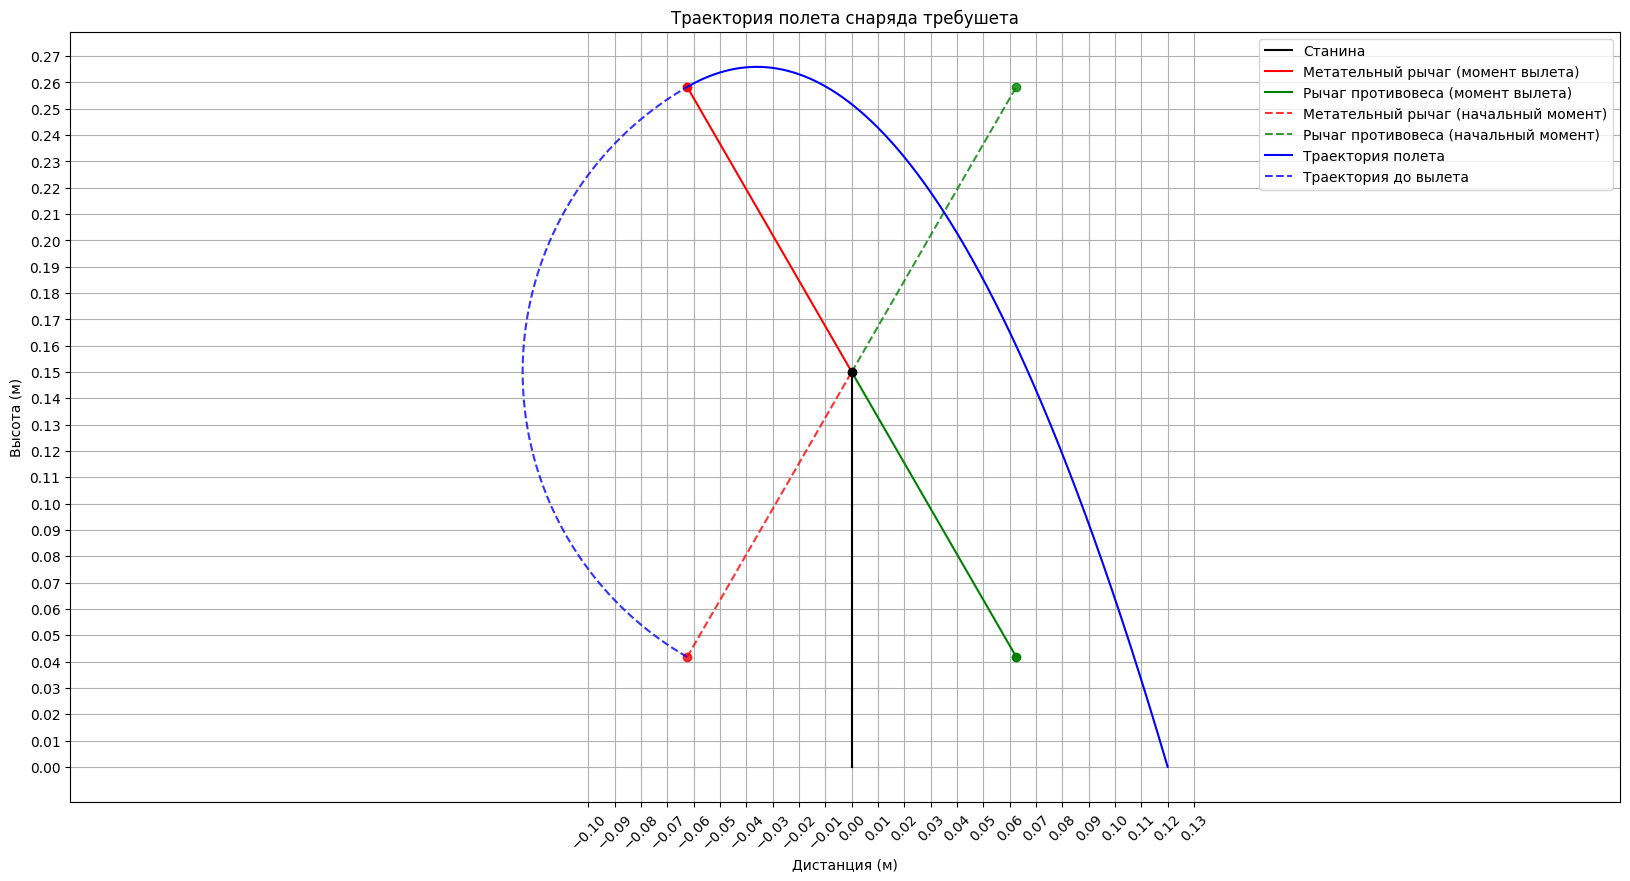

In [260]:
trebuchet = Trebuchet(arm_ratio=0.5, frame_height=0.15, arm_length=0.25, start_angle=150, release_angle=30, missile_mass=0.032, arm_mass=0.018)
# trebuchet.visualize(.5)
#0.21013092883839696 78.4532 0.26376710058151237 2.0606804732930653
trebuchet.visualize(.12)
#0.21013092883839696 78.4532 0.26376710058151237 2.0606804732930653

#### Запись испытаний
Попрыгун весит ~10.5 грамм
Шар весит ~ 16 грамм

Испытания с попрыгуном / расчеты с попрыгуном / реальная масса:
1 шар - 15см / 28гр / 16-25
2 шара - 30см / 37гр / 32-41
3 шара - 45см / 47гр / 48-57
4 шара - 60см / 58гр / 64-73

Испытания с шаром / расчеты с шаром:
1 шар - 7см / 38гр / 16-25
2 шара - 15см / 42гр / 32-41
3 шара - 30см / 53гр / 48-57
4 шара - 50см / 71гр / 64-73

и еще 2 шара на противовесе 3ех шаров - 12см / 79гр / 64-73

In [224]:
def objective_function(params, target_distance, trebuchet_class, missile_mass=0.0105, arm_mass=0.018, frame_height=0.15, start_angle=140):
    arm_ratio, arm_length, release_angle = params

    # Создаем экземпляр требушета с текущими параметрами
    trebuchet = trebuchet_class(
        arm_ratio=arm_ratio,
        arm_length=arm_length,
        frame_height=frame_height,
        start_angle=start_angle,
        release_angle=release_angle,
        missile_mass=missile_mass,
        arm_mass=arm_mass,
        logging_level=0
    )

    # Вычисляем начальную скорость и дальность
    v0 = trebuchet.calculate_launch_velocity(target_distance)
    distance = trebuchet.trajectory(v0)[2][-1]
    weight_mass = trebuchet.calculate_weight_mass(v0)
    print(f"arm_ratio:{params[0]}, arm_length: {params[1]}, angle:{params[2]}")
    print(f"{weight_mass:.2f} Kg")

    # Целевая функция — квадрат ошибки
    return abs(distance - target_distance) + weight_mass


def constraint(params):
    arm_ratio, arm_length, _ = params
    return (1 - arm_ratio) * arm_length * np.sin(np.radians(165)) - arm_length


def optimize_trebuchet_scipy(trebuchet_class, target_distance):
    initial_params = [0.2, 0.25, 45.0]  # [arm_ratio, arm_length, release_angle]

    # Ограничения для параметров
    bounds = [
        # (0.01, 0.99),  # arm_ratio
        (0.5, 0.5),  # arm_ratio
        (0.01, 0.25),  # arm_length
        # (1.0, 89.0)  # release_angle
        (30.0, 30.0)  # release_angle
    ]

    # con = {'type': 'ineq', 'fun': constraint}

    # Оптимизация
    result = minimize(
        objective_function,
        x0=initial_params,
        args=(target_distance, trebuchet_class),
        bounds=bounds,
        # constraints=[con],
        method='L-BFGS-B'
    )

    return result.x  # Возвращаем оптимизированные параметры

In [225]:
target_distance = 0.5
optimized_params = optimize_trebuchet_scipy(Trebuchet, target_distance)

print(f"Optimized parameters: arm_ratio={optimized_params[0]:.5f}, arm_length={optimized_params[1]:.5f}, release_angle={optimized_params[2]:.5f}")

230.0 119.99999999999999
weight delta y 0.2040087308629271
first_path_time 0.09603898366160742
max_y 0.3034789268407745
second_path_time 0.24878198568090912
total_time 0.34482096934251655
0.20397598410105902 73.87698729540485 0.1582258774530172 1.8836413982502047
0.021006743315427703
arm_ratio:0.5, arm_length: 0.25, angle:30.0
0.05 Kg
230.0 119.99999999999999
weight delta y 0.20400872270257786
first_path_time 0.09603898371029859
max_y 0.3034789225565058
second_path_time 0.24878198392485823
total_time 0.3448209676351568
0.2039759800215393 73.87699176547949 0.15822588386227213 1.8836413992051995
0.02100674247515797
arm_ratio:0.5, arm_length: 0.24999999, angle:30.0
0.05 Kg
230.0 119.99999999999999
weight delta y 0.19864479815417374
first_path_time 0.0960716058409213
max_y 0.3006633920947925
second_path_time 0.24762525540340175
total_time 0.343696861244323
0.20127658646824226 76.91552470899458 0.16255358972832182 1.8842812268397418
0.020454420103095592
arm_ratio:0.5, arm_length: 0.24342683

In [226]:
# trebuchet = Trebuchet(arm_ratio=0.474, frame_height=0.15, arm_length=0.25, start_angle=31, release_angle=40, missile_mass=0.03, arm_mass=0.07)
# trebuchet.visualize(50)